In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule
import time

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 128

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


NameError: name 'List' is not defined

In [2]:
tag_dep_seq_sent = TextGraphType.DEPENDENCY | TextGraphType.TAGS | TextGraphType.SEQUENTIAL
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=True, num_data_load = 1000, device='cpu', batch_size=batch_size, graph_type=tag_dep_seq_sent, load_preprocessed_data = True)

self.num_data_load: 110000
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AmazonReview\dep_and_tag\graph_var.txt
 0 graph loaded
 100 graph loaded
 200 graph loaded
 300 graph loaded
 400 graph loaded
 500 graph loaded
 600 graph loaded
 700 graph loaded
 800 graph loaded
 900 graph loaded
 1000 graph loaded
 1100 graph loaded
 1200 graph loaded
 1300 graph loaded
 1400 graph loaded
 1500 graph loaded
 1600 graph loaded
 1700 graph loaded
 1800 graph loaded
 1900 graph loaded
 2000 graph loaded
 2100 graph loaded
 2200 graph loaded
 2300 graph loaded
 2400 graph loaded
 2500 graph loaded
 2600 graph loaded
 2700 graph loaded
 2800 graph loaded
 2900 graph loaded
 3000 graph loaded
 3100 graph loaded
 3200 graph loaded
 3300 graph loaded
 3400 graph loaded
 3500 graph loaded
 3600 graph loaded
 3700 graph loaded
 3800 graph loaded
 3900 graph loaded
 4000 graph loaded
 4100 graph loaded
 4200 graph loaded
 4300 graph loaded
 4400 graph loaded
 4500 graph loaded
 460

In [3]:
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))

In [40]:
X1.metadata()

(['dep', 'word', 'tag', 'general'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_word', 'word'),
  ('word', 'word_general', 'general')])

In [44]:
torch.max(X1.edge_attr_dict[ ('word', 'word_general', 'general')])

tensor(0.2236, device='cuda:0')

In [4]:
# X1.x_dict['dep']

In [5]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, BatchNorm, SAGEConv
class HeteroGCNConv(nn.Module):
    def __init__(self, in_feature, out_feature, dropout = 0.0, num_heads: int = 1) -> None:
        super().__init__()
        self.conv1 = GATv2Conv(in_feature, int(out_feature/num_heads), heads=num_heads, edge_dim=1, add_self_loops=False)
        # self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_weights: Tensor) -> Tensor:
        x = self.conv1(x, edge_index)
        # x = self.batch_norm(x)
        # x = F.leaky_relu(x)
        # x = self.dropout(x)
        return x

In [6]:
# from torch_geometric.nn import to_hetero
# hetero_model = to_hetero(HeteroGCNConv(300, 1024, 0.2), X2.metadata())
# pre = hetero_model(X2.x_dict, X2.edge_index_dict, X2.edge_attr_dict)

In [7]:
X1.metadata()

(['dep', 'word', 'tag', 'general'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_word', 'word'),
  ('word', 'word_general', 'general')])

In [153]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
import torch
from typing import Dict
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv, DenseGCNConv, dense_diff_pool, BatchNorm, global_mean_pool, global_add_pool, global_max_pool, MemPooling, SAGEConv, to_hetero, HeteroBatchNorm, MeanSubtractionNorm, PairNorm
from torch_geometric.nn import Sequential as GSequential
from torch_geometric.utils import to_dense_adj
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.data import HeteroData
class HeteroGcnGatModel1(torch.nn.Module):
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 base_hidden_feature: int=256,
                 dropout=0.1):
        
        super(HeteroGcnGatModel1, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.bsh: int = base_hidden_feature
        bsh2: int = int(self.bsh/2)
        bsh4: int = int(self.bsh/4)
        bsh8: int = int(self.bsh/8)
        
        self.reduce_overfitting = PairNorm()
        self.conv1 = to_hetero(HeteroGCNConv(input_feature, self.bsh, dropout), metadata)
        self.conv2 = to_hetero(HeteroGCNConv(self.bsh, bsh2, dropout, num_heads=4), metadata)
        self.conv3 = to_hetero(HeteroGCNConv(bsh2, bsh4, dropout, num_heads=2), metadata)
        self.conv4 = to_hetero(HeteroGCNConv(bsh4, bsh4, dropout, num_heads=2), metadata)
        self.conv5 = to_hetero(HeteroGCNConv(bsh4, bsh8, dropout), metadata)
        self.conv6 = to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata)
        self.conv7 = to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata)
        
        
        
        # self.conv4 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata)
        # self.conv5 = to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata)
            
        # self.encoder = GSequential('x_dict, edge_index_dict, edge_weights_dict', [
        #     (to_hetero(HeteroGCNConv(input_feature, self.bsh, dropout), metadata), 'x_dict, edge_index_dict, edge_weights_dict ->x1'),
        #     (to_hetero(HeteroGCNConv(self.bsh, self.bsh, dropout), metadata), 'x1, edge_index_dict, edge_weights_dict ->x1'),
        #     (to_hetero(HeteroGCNConv(self.bsh, bsh2, dropout), metadata), 'x1, edge_index_dict, edge_weights_dict -> x2'),
        #     (to_hetero(HeteroGCNConv(bsh2, bsh2, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x2'),
        #     (to_hetero(HeteroGCNConv(bsh2, bsh2, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x2'),
        #     (lambda x1, x2: (x1, x2), 'x1, x2 -> x1, x2')
            
            # (to_hetero(HeteroGCNConv(bsh2, bsh4, dropout), metadata), 'x2, edge_index_dict, edge_weights_dict -> x3'),
            # (to_hetero(HeteroGCNConv(bsh4, bsh4, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x3'),
            # (to_hetero(HeteroGCNConv(bsh4, bsh4, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x3'),
            # (to_hetero(HeteroGCNConv(bsh4, bsh8, dropout), metadata), 'x3, edge_index_dict, edge_weights_dict -> x4'),
            # (to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata), 'x4, edge_index_dict, edge_weights_dict -> x4'),
            # (to_hetero(HeteroGCNConv(bsh8, bsh8, dropout), metadata), 'x4, edge_index_dict, edge_weights_dict -> x4'),
            # (lambda x1, x2, x3, x4: (x1, x2, x3, x4), 'x1, x2, x3, x4 -> x1, x2, x3, x4')
        # ])
        
        # print(f'bsh8: {bsh8}')
        # self.attention = GSequential('x3, x4, edge_index, edge_weights', [
        #     (GATv2Conv(bsh8, bsh8, 2, edge_dim=1, dropout=dropout), 'x4, edge_index, edge_weights ->x4'),
        #     (BatchNorm(bsh4), 'x4->x4'),
        #     (nn.ReLU(), 'x4->x4'),
            
        #     (GCN2Conv(bsh4, 0.5, 0.1, 2), 'x4, x3, edge_index, edge_weights->x3'),
        #     (BatchNorm(bsh4), 'x3->x3'),
        #     (nn.ReLU(), 'x3->x3'),
        #     (GCNConv(bsh4, bsh4), 'x3, edge_index, edge_weights -> x3'),
        #     (BatchNorm(bsh4), 'x3->x3'),
        #     (nn.ReLU(), 'x3->x3'),
            
        #     (GATv2Conv(bsh4, bsh4, 2, edge_dim=1, dropout=dropout), 'x3, edge_index, edge_weights ->x3'),
        #     (BatchNorm(bsh2), 'x3->x3'),
        #     (nn.ReLU(), 'x3->x3'),
        #     (lambda x3, x4: (x3, x4), 'x3, x4 -> x3, x4')
        # ])
        
        # self.decoder = GSequential('x1, x2, x3, edge_index, edge_weights', [
            
        #     (GCN2Conv(bsh2, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x2'),
        #     (BatchNorm(bsh2), 'x2->x2'),
        #     (nn.ReLU(), 'x2->x2'),
        #     (nn.Dropout(dropout), 'x2->x2'),
        # self.decoder = GSequential('x1, x2, edge_index, edge_weights', [
        #     (GCNConv(bsh2, bsh2), 'x2, edge_index, edge_weights -> x2'),
        #     (BatchNorm(bsh2), 'x2->x2'),
        #     (nn.ReLU(), 'x2->x2'),
        #     (nn.Dropout(dropout), 'x2->x2'),
        #     (GCNConv(bsh2, self.bsh), 'x2, edge_index->x2'),
        #     (BatchNorm(self.bsh), 'x2->x2'),
        #     (nn.ReLU(), 'x2->x2'),
        #     (nn.Dropout(dropout), 'x2->x2'),
            
        #     (GCN2Conv(self.bsh, 0.5, 0.1, 2), 'x2, x1, edge_index, edge_weights->x1'),
        #     (BatchNorm(self.bsh), 'x1->x1'),
        #     (nn.ReLU(), 'x1->x1'),
        #     (nn.Dropout(dropout), 'x1->x1'),
        #     (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
        #     (BatchNorm(self.bsh), 'x1->x1'),
        #     (nn.ReLU(), 'x1->x1'),
        #     (nn.Dropout(dropout), 'x1->x1'),
        #     (GCNConv(self.bsh, self.bsh), 'x1, edge_index, edge_weights ->x1'),
        #     (BatchNorm(self.bsh), 'x1->x1'),
        #     (nn.ReLU(), 'x1->x1'),
        #     (nn.Dropout(dropout), 'x1->x1')
        # ])
        self.mem_pool = MemPooling(bsh8, bsh8, 2, 8)
        self.output_layer = Linear(self.bsh, self.num_out_features)
        
        self.dep_embedding = torch.nn.Linear(45, 300)
        self.tag_embedding = torch.nn.Linear(50, 300)
        
        
    def forward(self, x: HeteroData) -> Tensor:
        # x1_dict, x2_dict = self.encoder(x.x_dict, x.edge_index_dict, x.edge_attr_dict)
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        x_dict['tag'] = self.tag_embedding(x_dict['tag'])
        x1_dict = self.conv1(x_dict, x.edge_index_dict, x.edge_attr_dict)
        # x1_dict['word'] = self.reduce_overfitting(x1_dict['word'], x['word'].batch)
        x2_dict = self.conv2(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        # x2_dict['word'] = self.reduce_overfitting(x2_dict['word'], x['word'].batch)
        x2_dict = self.conv3(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        # x2_dict['word'] = self.reduce_overfitting(x2_dict['word'], x['word'].batch)
        
        x2_dict = self.conv4(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        # x2_dict['word'] = self.reduce_overfitting(x2_dict['word'], x['word'].batch)
        x2_dict = self.conv5(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        # x2_dict['word'] = self.reduce_overfitting(x2_dict['word'], x['word'].batch)
        x2_dict = self.conv6(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        # x2_dict['word'] = self.reduce_overfitting(x2_dict['word'], x['word'].batch)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        x2_dict = self.conv7(x2_dict, x.edge_index_dict, x.edge_attr_dict)
        
        # x2_dict['word'] = self.reduce_overfitting(x2_dict['word'], x['word'].batch)
                
        # x1_dict = self.conv4(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        # x1_dict = self.conv5(x1_dict, x.edge_index_dict, x.edge_attr_dict)
        
        # x1_dict, x2_dict, x3_dict, x4_dict = self.encoder(x.x_dict, x.edge_index_dict, x.edge_attr_dict)
        # x_att, x4 = self.attention(x3_dict["word"], x4_dict["word"], 
        #                            x.edge_index_dict[('word', 'seq', 'word')],
        #                            x.edge_attr_dict[('word', 'seq', 'word')])
        # x_dec = self.decoder(x1_dict["word"], x2_dict["word"], x_att, 
        #                      x.edge_index_dict[('word', 'seq', 'word')],
        #                      x.edge_attr_dict[('word', 'seq', 'word')])
        x_pooled, S = self.mem_pool(x2_dict['word'], x['word'].batch)
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        out = self.output_layer(x_pooled)
        return out

In [154]:
torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 256, dropout=0.2)
torch_model = torch_model.to(device)
print(next(iter(torch_model.parameters())).device)
print(torch_geometric.nn.summary(torch_model, X1.to(device)))

cuda:0
+----------------------------------------------------+--------------------------+-----------------------------+-----------+
| Layer                                              | Input Shape              | Output Shape                | #Param    |
|----------------------------------------------------+--------------------------+-----------------------------+-----------|
| HeteroGcnGatModel1                                 | [48424, 48424]           | [256, 1]                    | 1,820,367 |
| ├─(reduce_overfitting)MeanSubtractionNorm          | --                       | --                          | --        |
| ├─(conv1)GraphModule                               |                          |                             | 1,086,208 |
| │    └─(conv1)ModuleDict                           | --                       | --                          | 1,084,160 |
| │    │    └─(dep__dep_word__word)GATv2Conv         | [2, 22411]               | [23848, 256]                | 154,880   |
|

In [155]:
from Scripts.Models.LightningModels.LightningModels import BinaryLightningModel
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [156]:
callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
    # EarlyStopping(patience=50, mode='max', monitor='val_acc')
]
lightning_model = BinaryLightningModel(torch_model,
                                 torch.optim.Adam(torch_model.parameters(), lr=0.001, weight_decay=0.001),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=00.001,
                                       batch_size=batch_size,
                                       ).to(device)
model_manager = ClassifierModelManager(torch_model, lightning_model, model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs', log_name='hetero_model_2', device=device, num_train_epoch=500)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00030199517204020147
Restoring states from the checkpoint path at C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\.lr_find_a447e00f-8b29-4736-8064-17da8c823c64.ckpt
Restored all states from the checkpoint at C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\.lr_find_a447e00f-8b29-4736-8064-17da8c823c64.ckpt
c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\ModelsManager\ModelManager.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.00030199517204020147

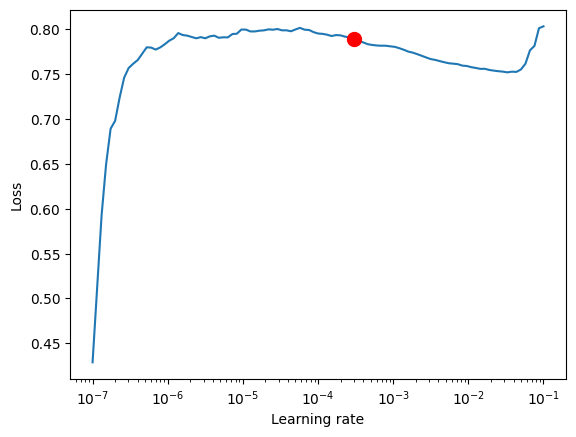

In [157]:
model_manager.tune(data_manager)

In [158]:
model_manager.fit(datamodule=data_manager)

bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.281     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [144]:
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=500,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='hetero_gnn_1'),
            num_sanity_val_steps=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [145]:
tuner = Tuner(trainer)
results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.0000001,max_lr=0.1)


Missing logger folder: logs/hetero_gnn_1


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.05754399373371567
Restoring states from the checkpoint path at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_3639a14d-95d8-405f-bf29-6fc55c15dcab.ckpt
Restored all states from the checkpoint at c:\Users\fardin\Projects\ColorIntelligence\.lr_find_3639a14d-95d8-405f-bf29-6fc55c15dcab.ckpt


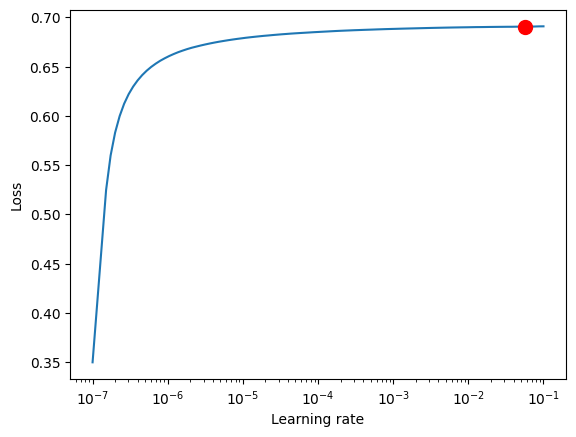

In [146]:
fig = results.plot(suggest=True)

In [139]:
# next(iter(trainer.model.optimizer.param_groups))

In [140]:
trainer.fit(model=lightning_model, datamodule=data_manager)

bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | HeteroGcnGatModel1 | 1.8 M 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | BinaryAccuracy     | 0     
3 | val_acc   | BinaryAccuracy     | 0     
4 | test_acc  | BinaryAccuracy     | 0     
-------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.281     Total estimated model params size (MB)


RuntimeError: Missing folder: logs/HeteroGat1\version_17.

In [15]:
trainer.checkpoint_callback.best_model_path

'logs/HeteroGat1\\version_17\\checkpoints\\epoch=10-step=2827.ckpt'

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from os import path
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)

    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()

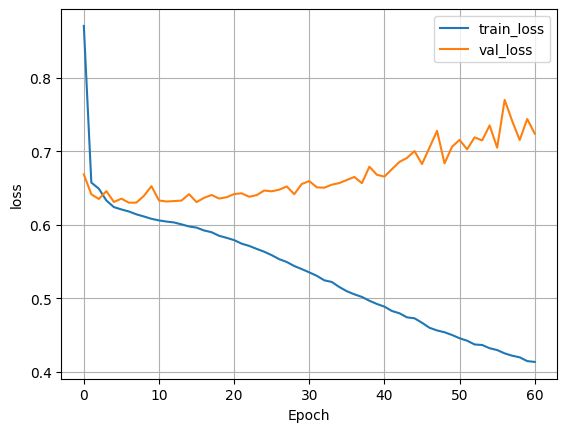

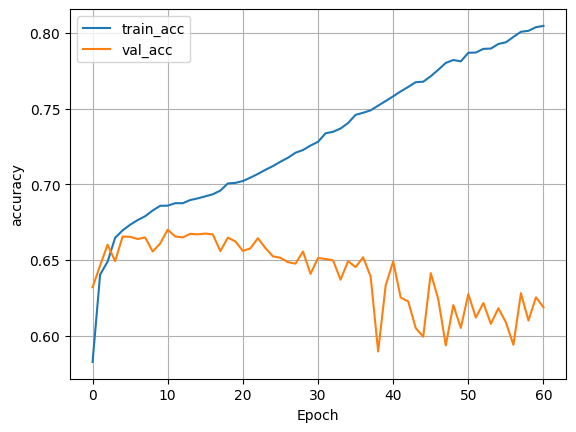

In [25]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\HeteroGat1\version_17\metrics.csv')